# Select EPIC PN observations according to some criteria

In [1]:
import os
import tarfile
import subprocess
import sys
import requests
import logging
import pandas as pd

from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')
sys.path.append(home + '/IVAN/python')

from xmm_tools import *

In [33]:
def fit_cu_line(xin,yin, minMax=(7.0,9.0),line_c=8.0):
    # xin is the energy in keV
    m1 = xin >= minMax[0]
    m2 = xin <= minMax[1]
    xw = xin[m1*m2]
    yw = yin[m1*m2]
    i1max = np.argmax(yw)
    y1max = yw[i1max]
    #x1max = xw[i1max]
    #
    poly_mod = PolynomialModel(1,prefix='poly_')
    pars = poly_mod.guess(yw, x=xw)
    #
    gauss1  = GaussianModel(prefix='g1_')
    pars.update( gauss1.make_params())
    pars['g1_center'].set(line_c,min=line_c-0.1,max=line_c+0.1)
    pars['g1_sigma'].set(0.08,min=0.04,max=0.250)
    pars['g1_amplitude'].set(y1max)
    #
    mod = poly_mod + gauss1
    #init = mod.eval(pars, x=x)
    out = mod.fit(yw, pars, x=xw)
    #
    cen = out.params['g1_center'].value
    cen_err = out.params['g1_center'].stderr
    fwhm = out.params['g1_fwhm'].value
    fwhm_err = out.params['g1_fwhm'].stderr
    #peak = out.params['g1_amplitude'].value/expo1
    #peak_err = out.params['g1_amplitude'].stderr/expo1
    chi2 = out.chisqr
    df = len(xw)
    results  = f"{cen:.3f},{cen_err:.3f},{fwhm:.5f},{fwhm_err:.5f},{chi2:.3f},{df}"
    return (out,results)


In [2]:
#
# first load the observations from EPICMON account
#

obs_table = read_pn_obstable()
# 
# convert to pandas dataframe
#
obs_tab = obs_table.to_pandas()
# and select all Large Window Mode and duration more thna 100 ks
#

In [3]:
obs_tab

,rev,ac_obs_id,ac_exp_id,exp_start_time,exp_end_time,perf_dur,mode,filter,target,s_obs_id,s_exp_id,ro,rx,rs
0,46,99300401,5,2000-03-10 23:47:36+00,2000-03-11 00:55:24+00,0,Full Frame,CLOSED,Sco X-1,99300401,5,0,0,0
1,46,99300401,414,2000-03-11 00:55:25+00,2000-03-11 01:03:02+00,-1,Noise,CLOSED,Sco X-1,99300401,414,0,0,0
2,46,120900201,12,2000-03-09 12:52:38+00,2000-03-10 02:48:46+00,0,Full Frame,THICK,Capella off-axis,120900201,12,0,0,0
3,46,120900201,458,2000-03-10 02:48:47+00,2000-03-10 02:56:24+00,-1,Noise,THICK,Capella off-axis,120900201,458,0,0,0
4,46,99300301,22,2000-03-10 09:45:53+00,2000-03-10 10:35:21+00,0,Full Frame,CLOSED,Sco X-1,99300301,22,0,0,0
5,46,99300301,414,2000-03-10 10:35:22+00,2000-03-10 10:42:59+00,-1,Noise,CLOSED,Sco X-1,99300301,414,0,0,0
6,47,102580601,2,2000-03-12 09:22:14+00,2000-03-12 16:28:22+00,27942,Full Frame,MEDIUM,3C58 on-axis par,102580601,1,0,1,0
7,47,102580801,415,2000-03-12 02:48:03+00,2000-03-12 02:55:40+00,1,Noise,MEDIUM,3C58 offset 1,102580801,415,0,0,0
8,47,102580801,1,2000-03-11 13:46:54+00,2000-03-12 02:48:02+00,31601,Full Frame,MEDIUM,3C58 offset 1,102580801,1,0,0,0
9,47,113890601,414,2000-03-12 23:17:19+00,2000-03-12 23:24:56+00,1,Noise,THICK,NGC2516,113890601,414,0,0,0


In [35]:
#
texp_limit = 80000.0 # 
xmode = "Large Window"
twork = obs_tab[(obs_tab.perf_dur >= texp_limit) & (obs_tab['mode'].str.contains(xmode))]
print ("Found {} EPIC-PN observations in {} and exposure greater than {}".format(len(twork),xmode,texp_limit))

Found 77 EPIC-PN observations in Large Window and exposure greater than 80000.0


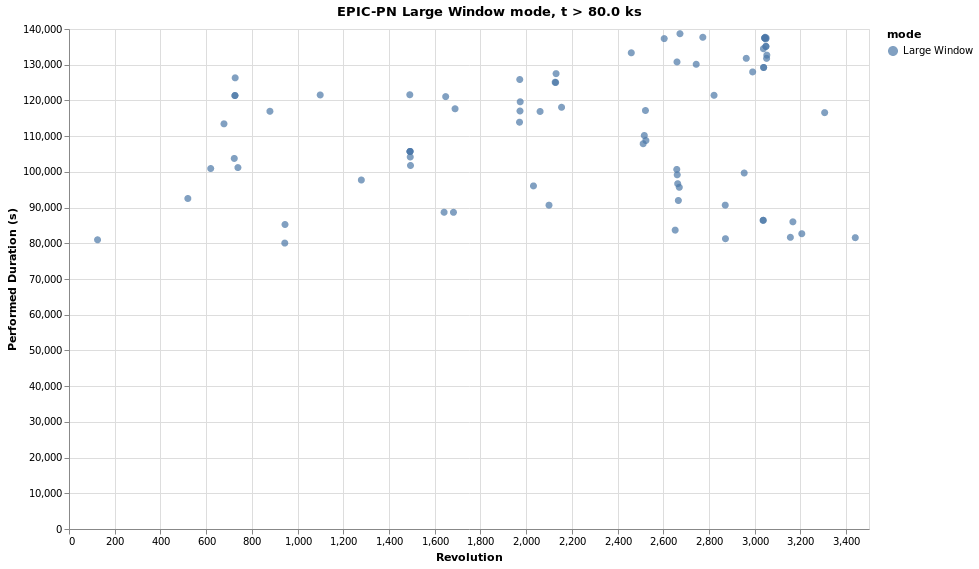

In [36]:
#
# plot the results using altair
import altair as alt

base = alt.Chart(twork,title=r"EPIC-PN {} mode, t > {} ks".format(xmode,texp_limit/1000.0),width=800,height=500)

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        "rev",
        #scale=alt.Scale(domain=(2500,3500)),
        axis=alt.Axis(title='Revolution')
    ),
    y=alt.Y(
        'perf_dur',
        #scale=alt.Scale(type='log',domain=(1,50000)),
        axis=alt.Axis(title="Performed Duration (s)")
    ),
    color='mode',
    tooltip=['rev', 'ac_obs_id','ac_exp_id','filter','target']
)
points

In [6]:
#
# now download an OBS_ID from NXSA and check for the Cu Ka line (8.04 keV)
#
# select a random OBS_ID from the table
#

obsid = "{:010}".format(twork.sample(n=1).ac_obs_id.values[0])
#print (f"Selected a random OBS_ID: {obsid}")
url = f"http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action-aio?obsno={obsid}&level=PPS&name=PIEVLI&instname=PN"
print (url)

http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action-aio?obsno=0400270101&level=PPS&name=PIEVLI&instname=PN


In [7]:
outputDir = home + '/IVAN/Cu-line'
ppsFile = f"{outputDir}/{obsid}_evlist.fits.gz"
#
if (not os.path.isfile(ppsFile)):
    print (f"No ODF tar file for OBSID {obsid}, downloading from NXSA")
    #with requests.post(url, auth=('ivaltch', 'XXXX')) as r:
    with requests.get(url) as r:
        r.raise_for_status() # ensure we notice bad responses
        with open(ppsFile,"wb") as tmp:
            tmp.write(r.content)
else:
    print (f"PPS event list file {ppsFile} found, will skip downloading it again")
print ("Ready")

No ODF tar file for OBSID 0400270101, downloading from NXSA
Ready


In [8]:
#
# now, extract per CCD the spectrum
#
evsel = "(PATTERN==0) && (PAT_SEQ==0) && #XMMEA_EP"
#
# now loop over all 12 CCDs in EPN
#
for i in range(12):
    ccd = f"{i+1:02}"
    print (f"Processing CCD # {ccd}")
    #
    mnk_mask =  f"/xdata/xcaldata/XMM/PN/CTI/mask/refmask_{ccd}_mnk_lmap.fits"
    #
    sel1 = f"mask({mnk_mask},1,1,RAWX,RAWY) && (CCDNR == {i+1})"
    spec_file = f"{outputDir}/{obsid}_pn_{ccd}_spec5.fits"
    command = "evselect " + \
        f"table={ppsFile} energycolumn='PI' withspectrumset=yes" + \
        f" expression='{evsel} && {sel1}'" + \
        " withspecranges=yes specchannelmin=0 specchannelmax=20479" + \
        f" spectrumset={spec_file} spectralbinsize=5"
    status = run_command(command)
    if (status != 0):
        raise Exception
#
print ("Extraction of per CCD spectra is done")

Processing CCD # 01


Execution returned 0


Processing CCD # 02


Execution returned 0


Processing CCD # 03


Execution returned 0


Processing CCD # 04


Execution returned 0


Processing CCD # 05


Execution returned 0


Processing CCD # 06


Execution returned 0


Processing CCD # 07


Execution returned 0


Processing CCD # 08


Execution returned 0


Processing CCD # 09


Execution returned 0


Processing CCD # 10


Execution returned 0


Processing CCD # 11


Execution returned 0


Processing CCD # 12


Execution returned 0


Fitting CCD #01 8.041,0.006,0.17468,0.01383,4264.888,401
Fitting CCD #02 8.028,0.001,0.17201,0.00328,6946.324,401
Fitting CCD #03 8.023,0.001,0.19207,0.00356,7057.890,401
Fitting CCD #04 8.086,0.015,0.14875,0.03750,23780.849,401
Fitting CCD #05 8.045,0.002,0.18785,0.00421,8932.467,401
Fitting CCD #06 8.051,0.001,0.17892,0.00329,6975.942,401
Fitting CCD #07 8.066,0.004,0.13785,0.00952,4204.475,401
Fitting CCD #08 8.051,0.002,0.19320,0.00384,6939.531,401
Fitting CCD #09 8.051,0.001,0.18048,0.00358,6782.272,401
Fitting CCD #10 8.052,0.005,0.18268,0.01213,4211.940,401
Fitting CCD #11 8.044,0.001,0.17990,0.00346,5822.862,401
Fitting CCD #12 8.051,0.002,0.17565,0.00387,4938.790,401


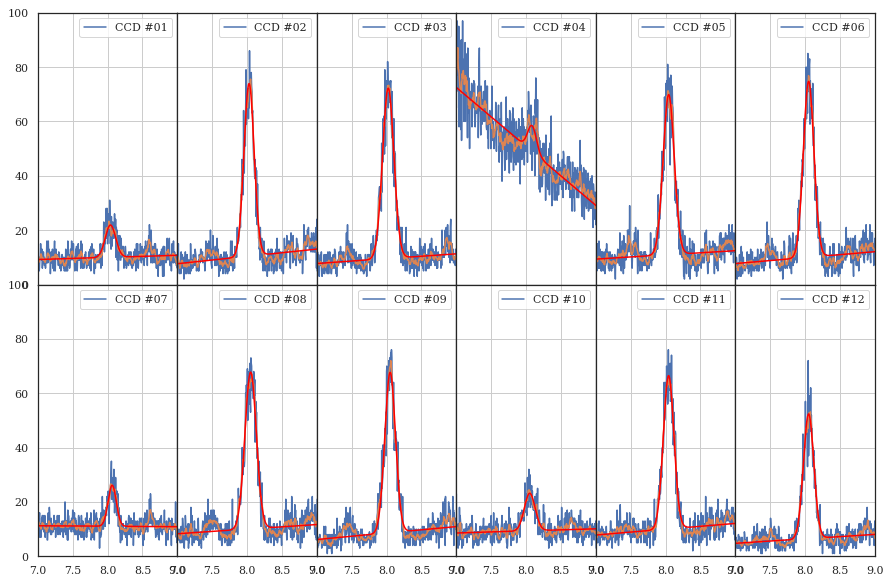

In [34]:
# Now plot
smooth = 7
fig, axs = plt.subplots(2,6,sharex=True,sharey=True,figsize=(15,10))
for j in range(12):
    ccd = j+1
    #slices = glob.glob(f"{specDir}/pn_{ccd:02}_180_spec5.fits")
    slices = f"{outputDir}/{obsid}_pn_{ccd:02}_spec5.fits"
    if (not os.path.isfile(slices)):
        raise FileNotFoundError
    hdu = fits.open(slices)
    spec = hdu['SPECTRUM']
    channel = spec.data['CHANNEL']*5.0/1000.0
    counts = spec.data['COUNTS']
    y = convolve(counts, Box1DKernel(smooth))
    # now fit a simple linear + Gauss line model
    #
    (fit_out,fit_res) = fit_cu_line(channel,counts,line_c=8.04)
    #
    yfitted = fit_out.eval(x=channel)
    print (f"Fitting CCD #{ccd:02}",fit_res)
    k = j
    kj = 0
    if (j >= 6):
        k = j - 6
        kj = 1
    axs[kj,k].plot(channel,counts,label=f'CCD #{ccd:02}')
    axs[kj,k].plot(channel,y,label='')
    axs[kj,k].plot(channel,yfitted,color='red',label='')
    axs[kj,k].set_xlim((7,9))
    axs[kj,k].set_ylim((0,100))
    axs[kj,k].grid(True)
    axs[kj,k].legend()
    #axs[kj,k].set_title(f"CCD #{ccd}")
#
plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
plt.show();
#plt.savefig(f"{wdir}/{obsid}_{expo}_allccd_plot.png",dpi=100)
#plt.close();